In [1]:
import warnings

warnings.filterwarnings("ignore")


In [2]:
import random

import numpy as np
import pandas as pd
import torch

from etna.analysis import plot_backtest
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MAPE
from etna.metrics import SMAPE
from etna.models import SeasonalMovingAverageModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform

In [3]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
# увеличиваем количество отображаемых столбцов
pd.set_option('display.max_columns', 200)
# настроим визуализацию
%config InlineBackend.figure_format = 'retina'

In [5]:
df = pd.read_excel("Data/rebar12price.xls")

df["timestamp"] = pd.to_datetime(df["date"])
df["target"] = df["price"]
df.drop(columns=["date", "price"], inplace=True)
df["segment"] = "segment_a"
df.head()


,timestamp,target,segment
0,2018-01-01,36699.994012,segment_a
1,2018-01-02,36699.994012,segment_a
2,2018-01-03,36699.994012,segment_a
3,2018-01-04,36699.994012,segment_a
4,2018-01-05,36699.994012,segment_a


In [6]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

In [7]:
ts.head()

segment,segment_a
feature,target
timestamp,
2018-01-01,36699.994012
2018-01-02,36699.994012
2018-01-03,36699.994012
2018-01-04,36699.994012
2018-01-05,36699.994012


In [8]:
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

In [9]:
HORIZON = 7
metrics = [SMAPE(), MAPE(), MAE()]

In [10]:
model_sma = SeasonalMovingAverageModel(window=5, seasonality=7)
linear_trend_transform = LinearTrendTransform(in_column="target")

pipeline_sma = Pipeline(model=model_sma, horizon=HORIZON, transforms=[linear_trend_transform])

In [11]:
metrics_sma, forecast_sma, fold_info_sma = pipeline_sma.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [12]:
metrics_sma

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,1.205403,1.194490,692.094614,0
0,segment_a,2.949464,2.898050,1713.764443,1
0,segment_a,5.117432,4.982763,3022.634397,2


In [13]:
score = metrics_sma["SMAPE"].mean()
print(f"Average SMAPE for Seasonal MA: {score:.3f}")

Average SMAPE for Seasonal MA: 3.091


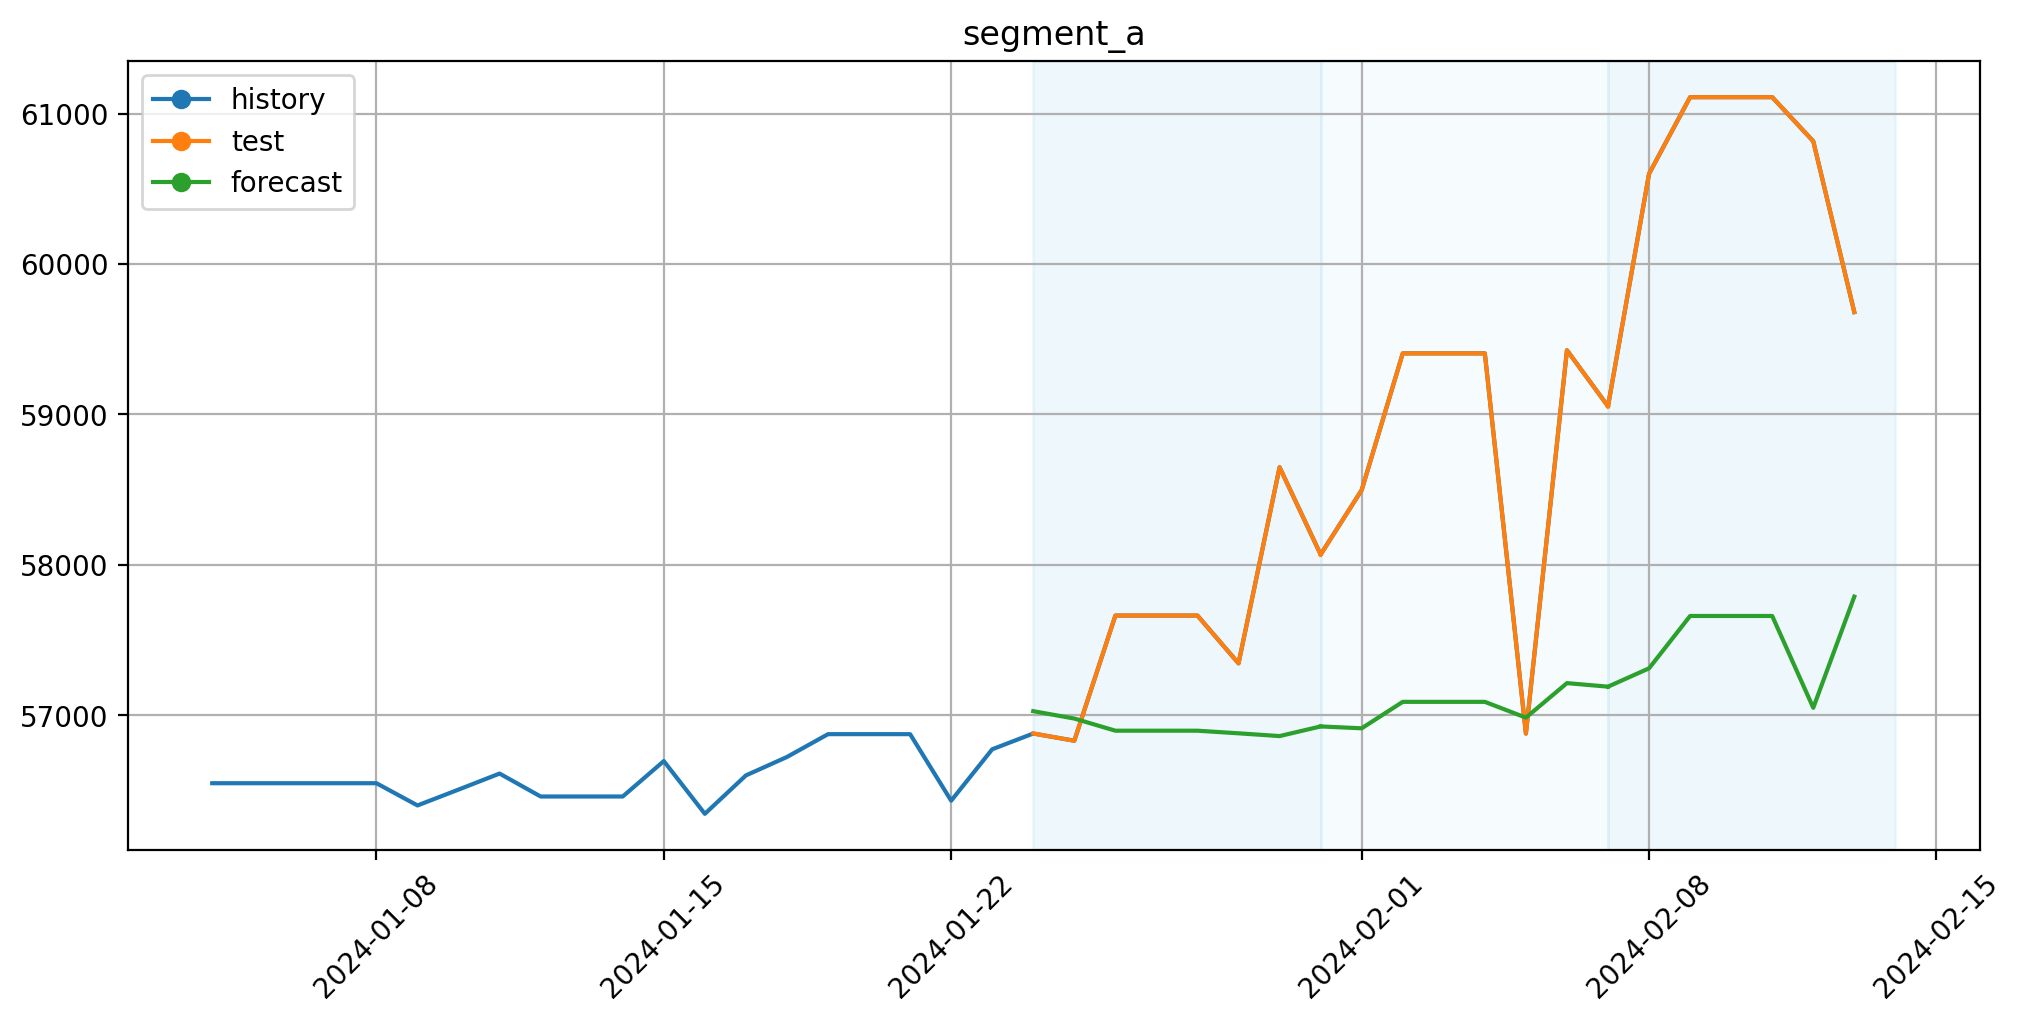

In [14]:
plot_backtest(forecast_sma, ts, history_len=20)

In [15]:
from etna.models.nn import DeepARModel

In [16]:
set_seed()

In [22]:
model_deepar = DeepARModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(model=model_deepar, horizon=HORIZON)

In [23]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.6min
/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear         

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  3.2min
/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear         

Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  3.5min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  3.5min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [45]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,1.621149,1.601714,927.756669,0
0,segment_a,1.630542,1.619756,954.034795,1
0,segment_a,2.521073,2.482739,1510.829844,2


In [46]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 1.924


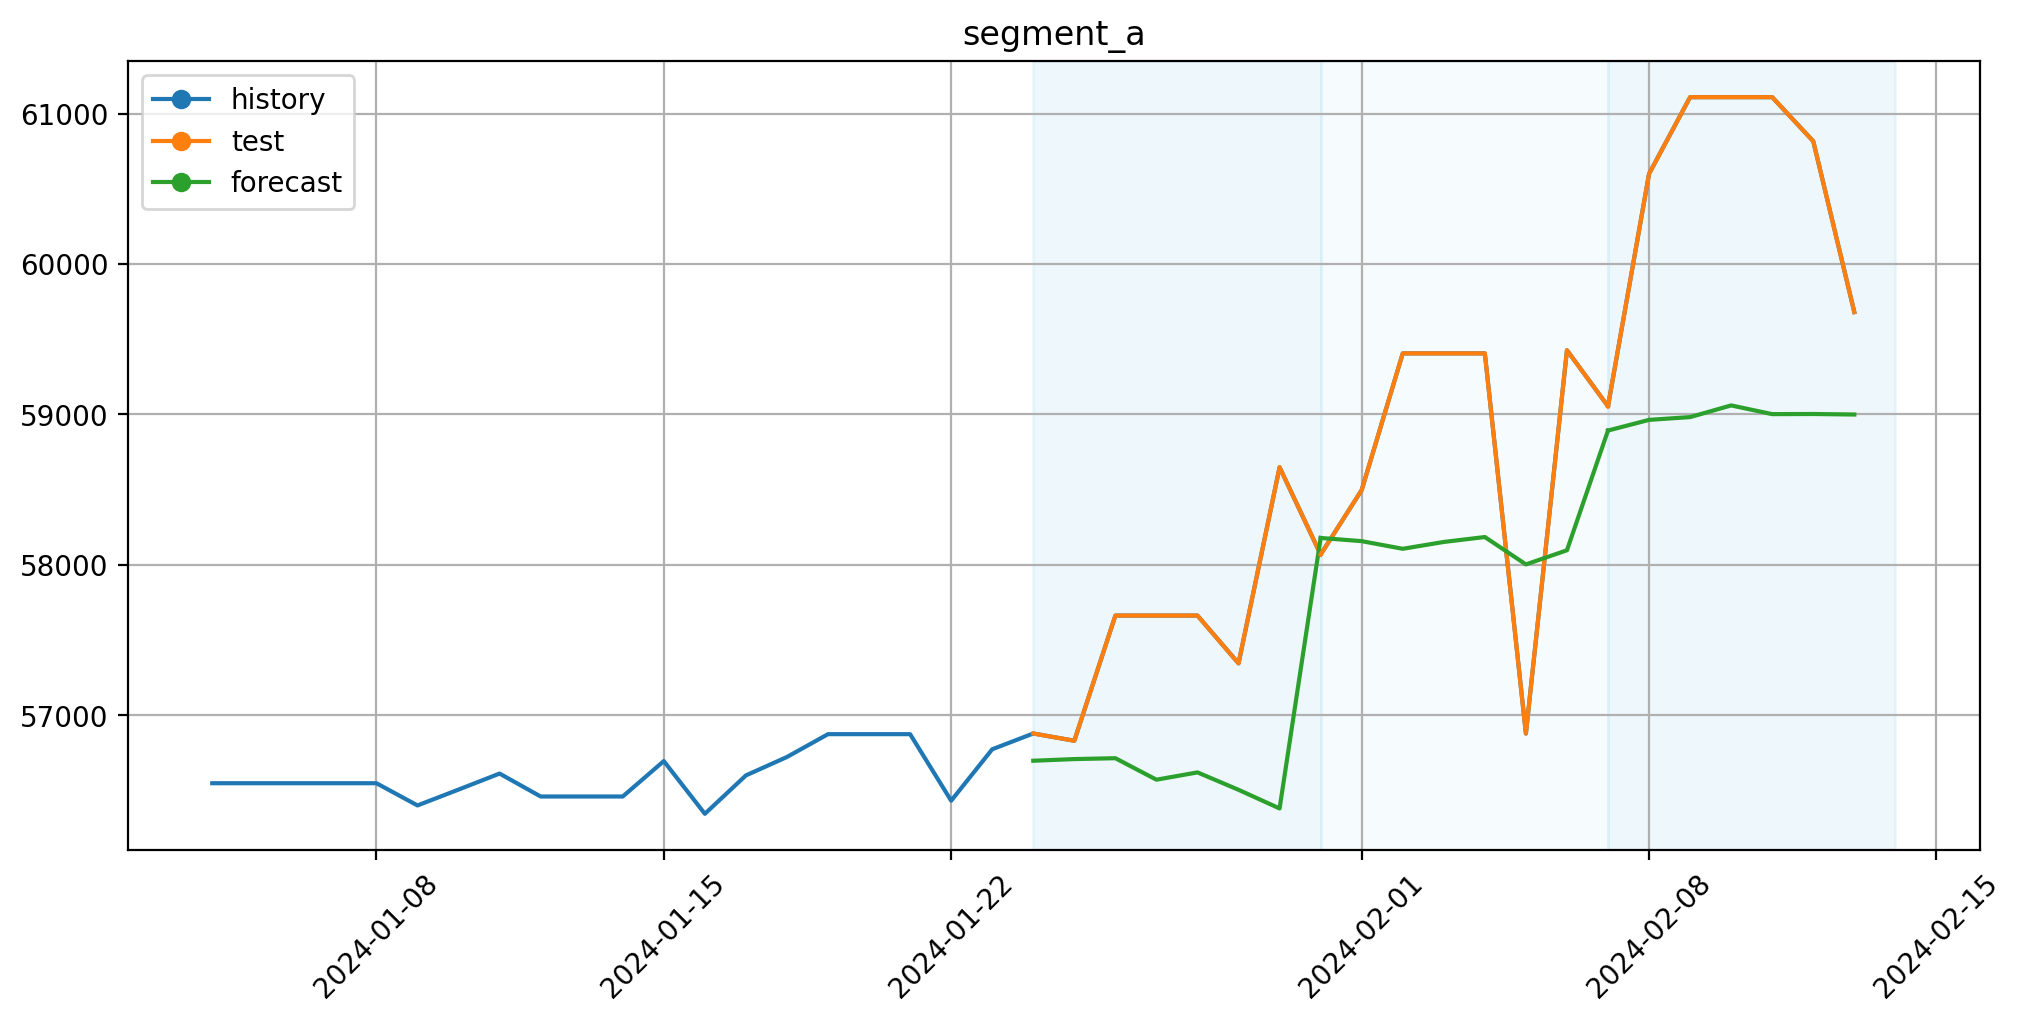

In [47]:
plot_backtest(forecast_deepar, ts, history_len=20)

In [48]:
from pytorch_forecasting.data import GroupNormalizer

set_seed()

transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

dataset_builder_deepar = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"] + lag_columns,
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

In [49]:
model_deepar = DeepARModel(
    dataset_builder=dataset_builder_deepar,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date],
)

In [50]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.8min
/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear         

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  3.5min
/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear         

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  5.3min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  5.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [51]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,1.738782,1.718361,994.355999,0
0,segment_a,1.881380,1.863575,1099.534938,1
0,segment_a,2.917287,2.868343,1744.047477,2


In [52]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 2.179


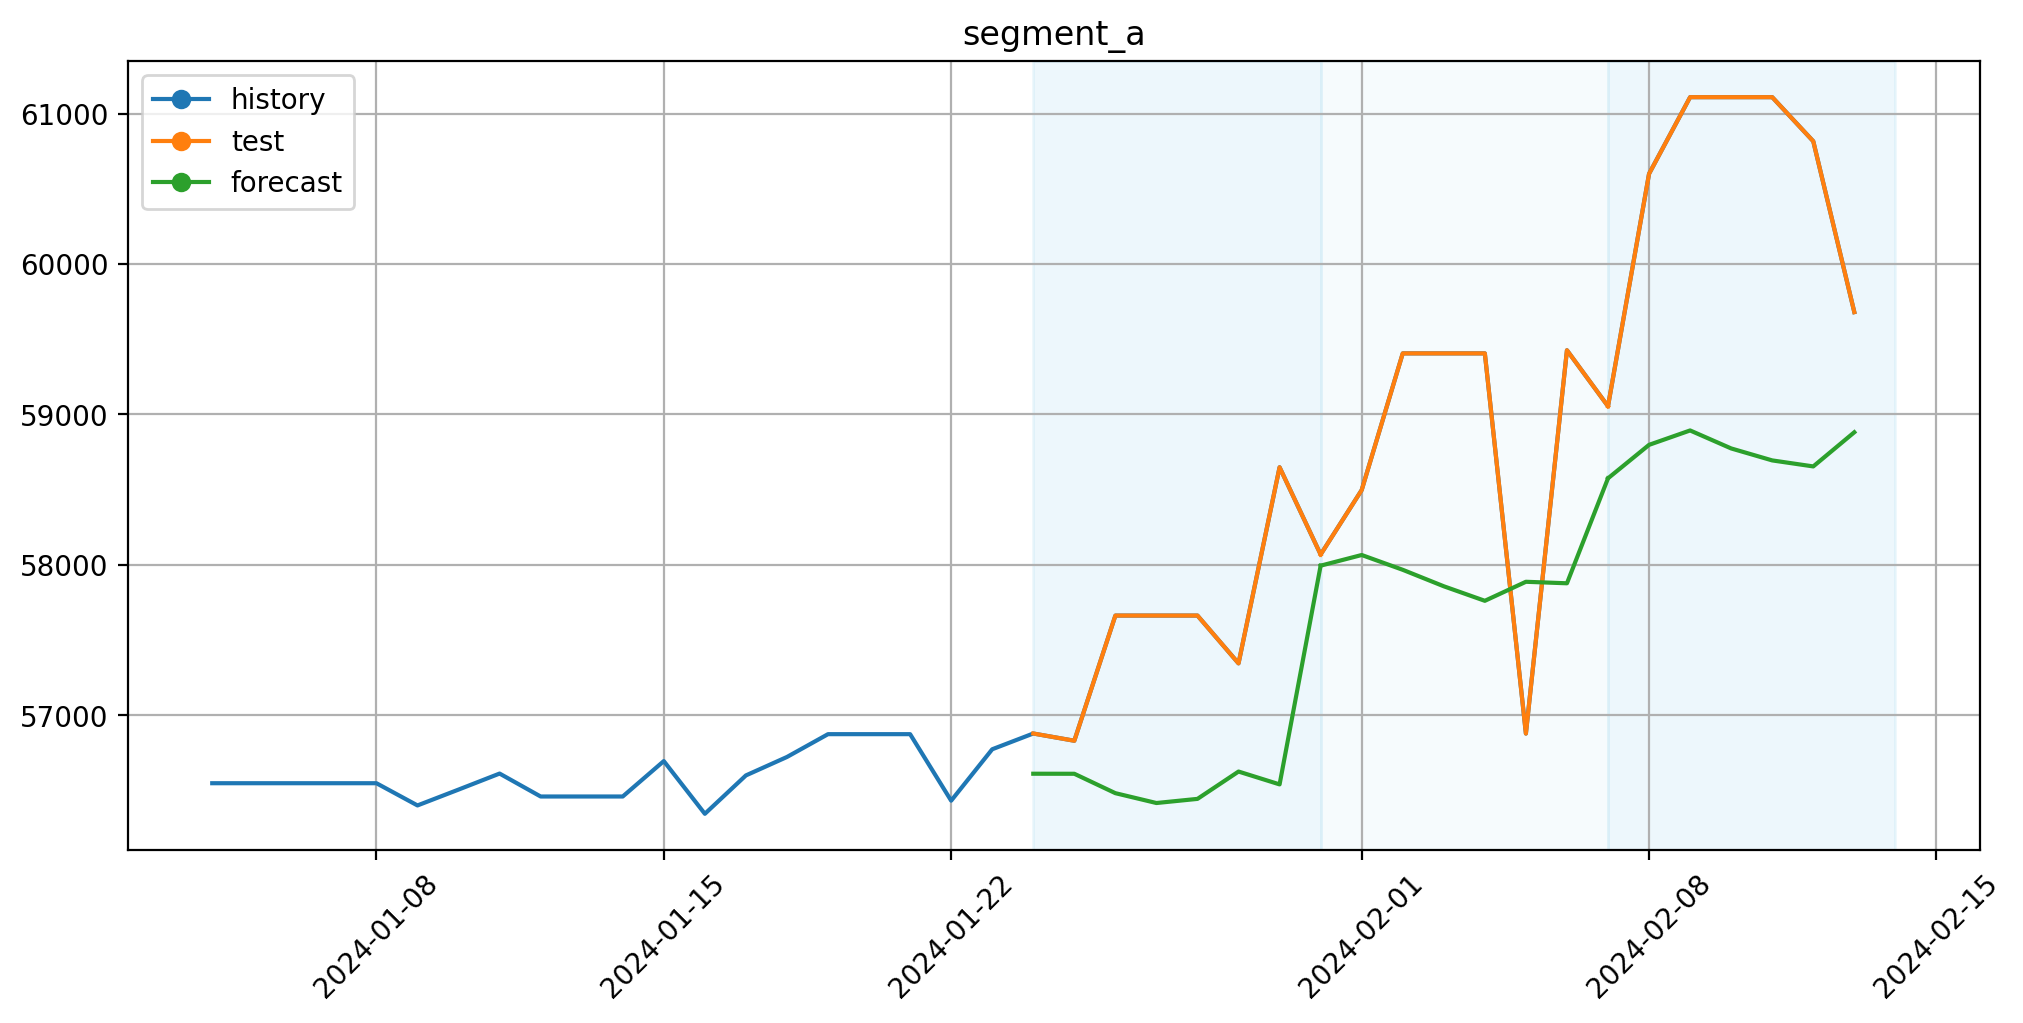

In [53]:
plot_backtest(forecast_deepar, ts, history_len=20)

In [54]:
from etna.models.nn import DeepARNativeModel
from etna.transforms import StandardScalerTransform

In [55]:
set_seed()

std = StandardScalerTransform(in_column="target")

model_deepar_native = DeepARNativeModel(
    input_size=1,
    encoder_length=2 * HORIZON,
    decoder_length=HORIZON,
    lr=0.01,
    scale=False,
    n_samples=100,
    train_batch_size=64,
    trainer_params=dict(max_epochs=30, gpus=0, gradient_clip_val=0.1),
)
pipeline_deepar_native = Pipeline(model=model_deepar_native, horizon=HORIZON, transforms=[std])

In [56]:
metrics_deepar_native, forecast_deepar_native, fold_info_deepar_native = pipeline_deepar_native.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type         | Params
--------------------------------------------
0 | loss       | GaussianLoss | 0     
1 | rnn        | LSTM         | 3.4 K 
2 | projection | ModuleDict   | 34    
--------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    8.5s
/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type         | Params
--------------------------------------------
0 | loss       | GaussianLoss | 0     
1 | rnn        | LSTM         | 3.4 K 
2 | projection | ModuleDict   | 34    
--------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   17.2s
/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type         | Params
--------------------------------------------
0 | loss       | GaussianLoss | 0     
1 | rnn        | LSTM         | 3.4 K 
2 | projection | ModuleDict   | 34    
--------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   26.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   26.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [57]:
score = metrics_deepar_native["SMAPE"].mean()
print(f"Average SMAPE for DeepARNative: {score:.3f}")

Average SMAPE for DeepARNative: 2.582


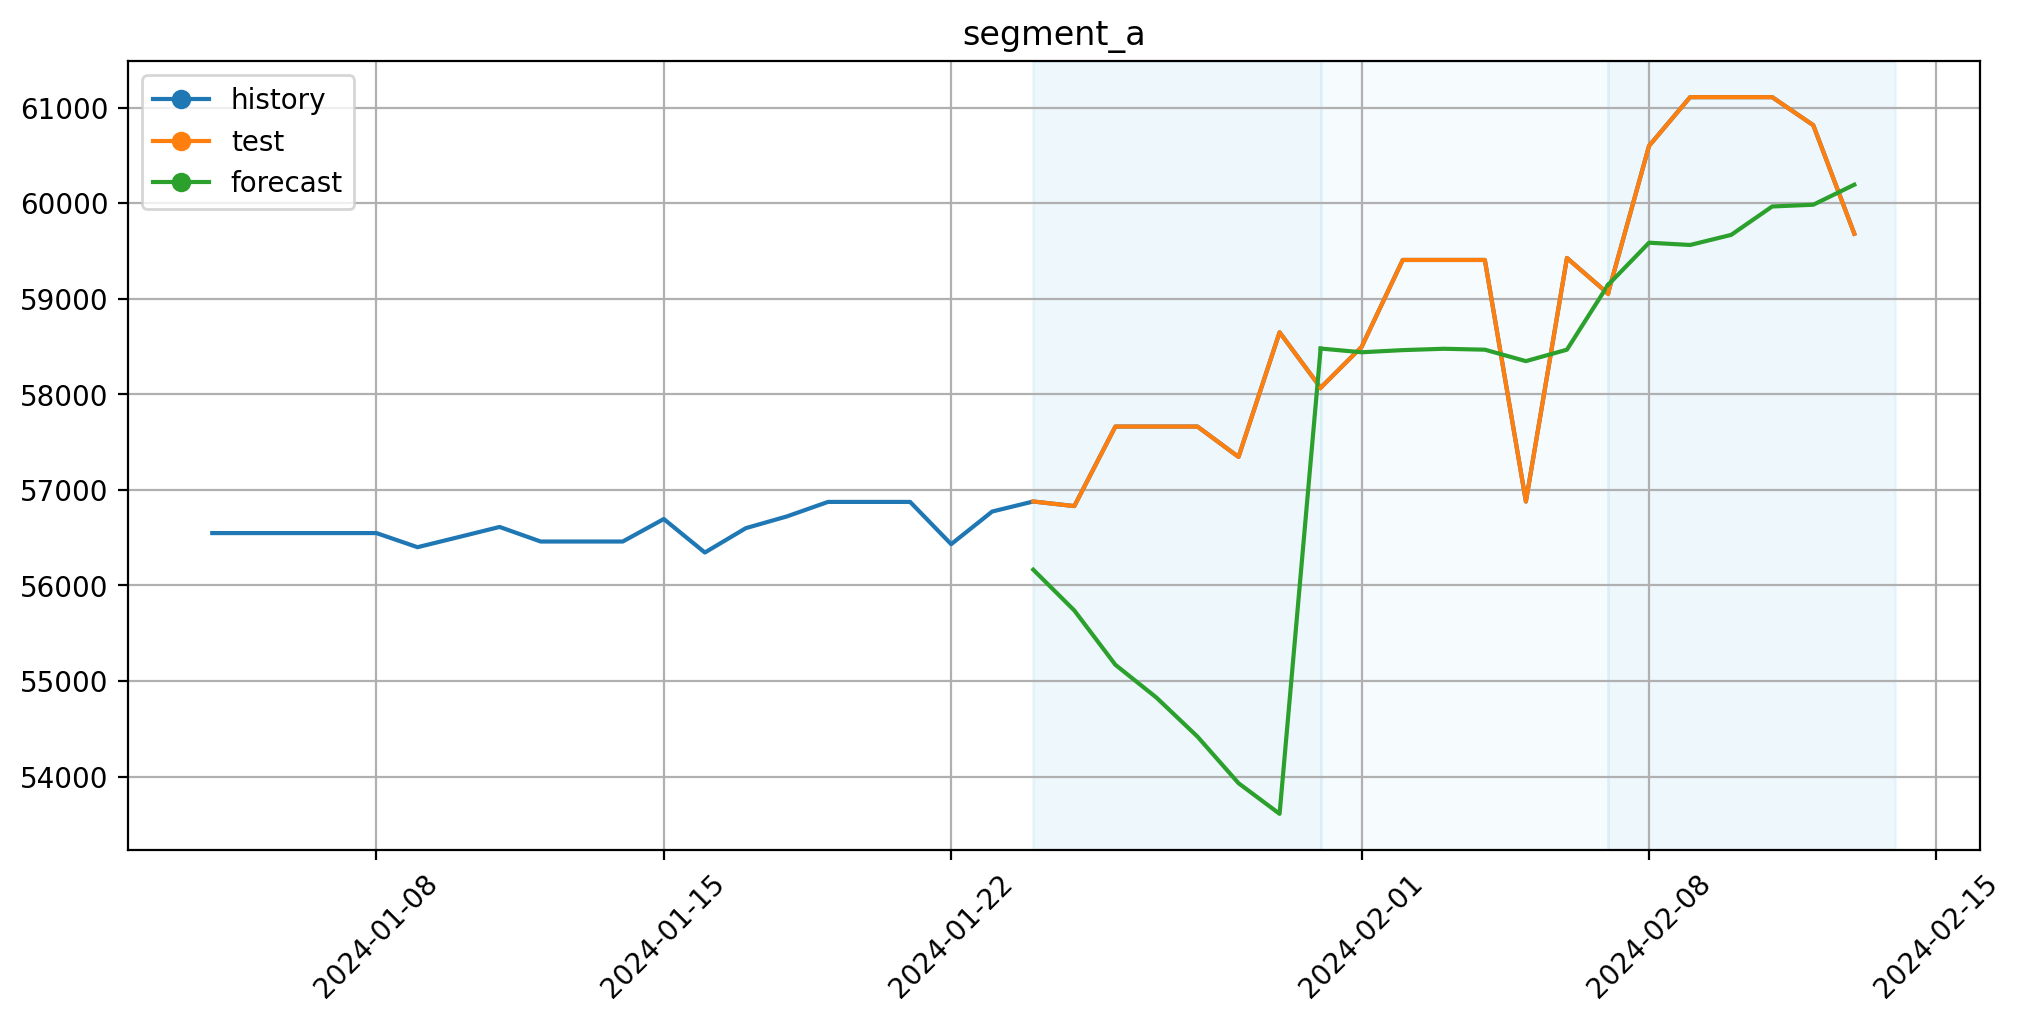

In [58]:
plot_backtest(forecast_deepar_native, ts, history_len=20)

In [59]:
from etna.models.nn import TFTModel

In [60]:
set_seed()

In [61]:
model_tft = TFTModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=200, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
)

In [62]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_s

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.3min
/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  8.5min
/Users/dim/anaconda3/envs/etna_new/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 12.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 12.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [63]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 73.485


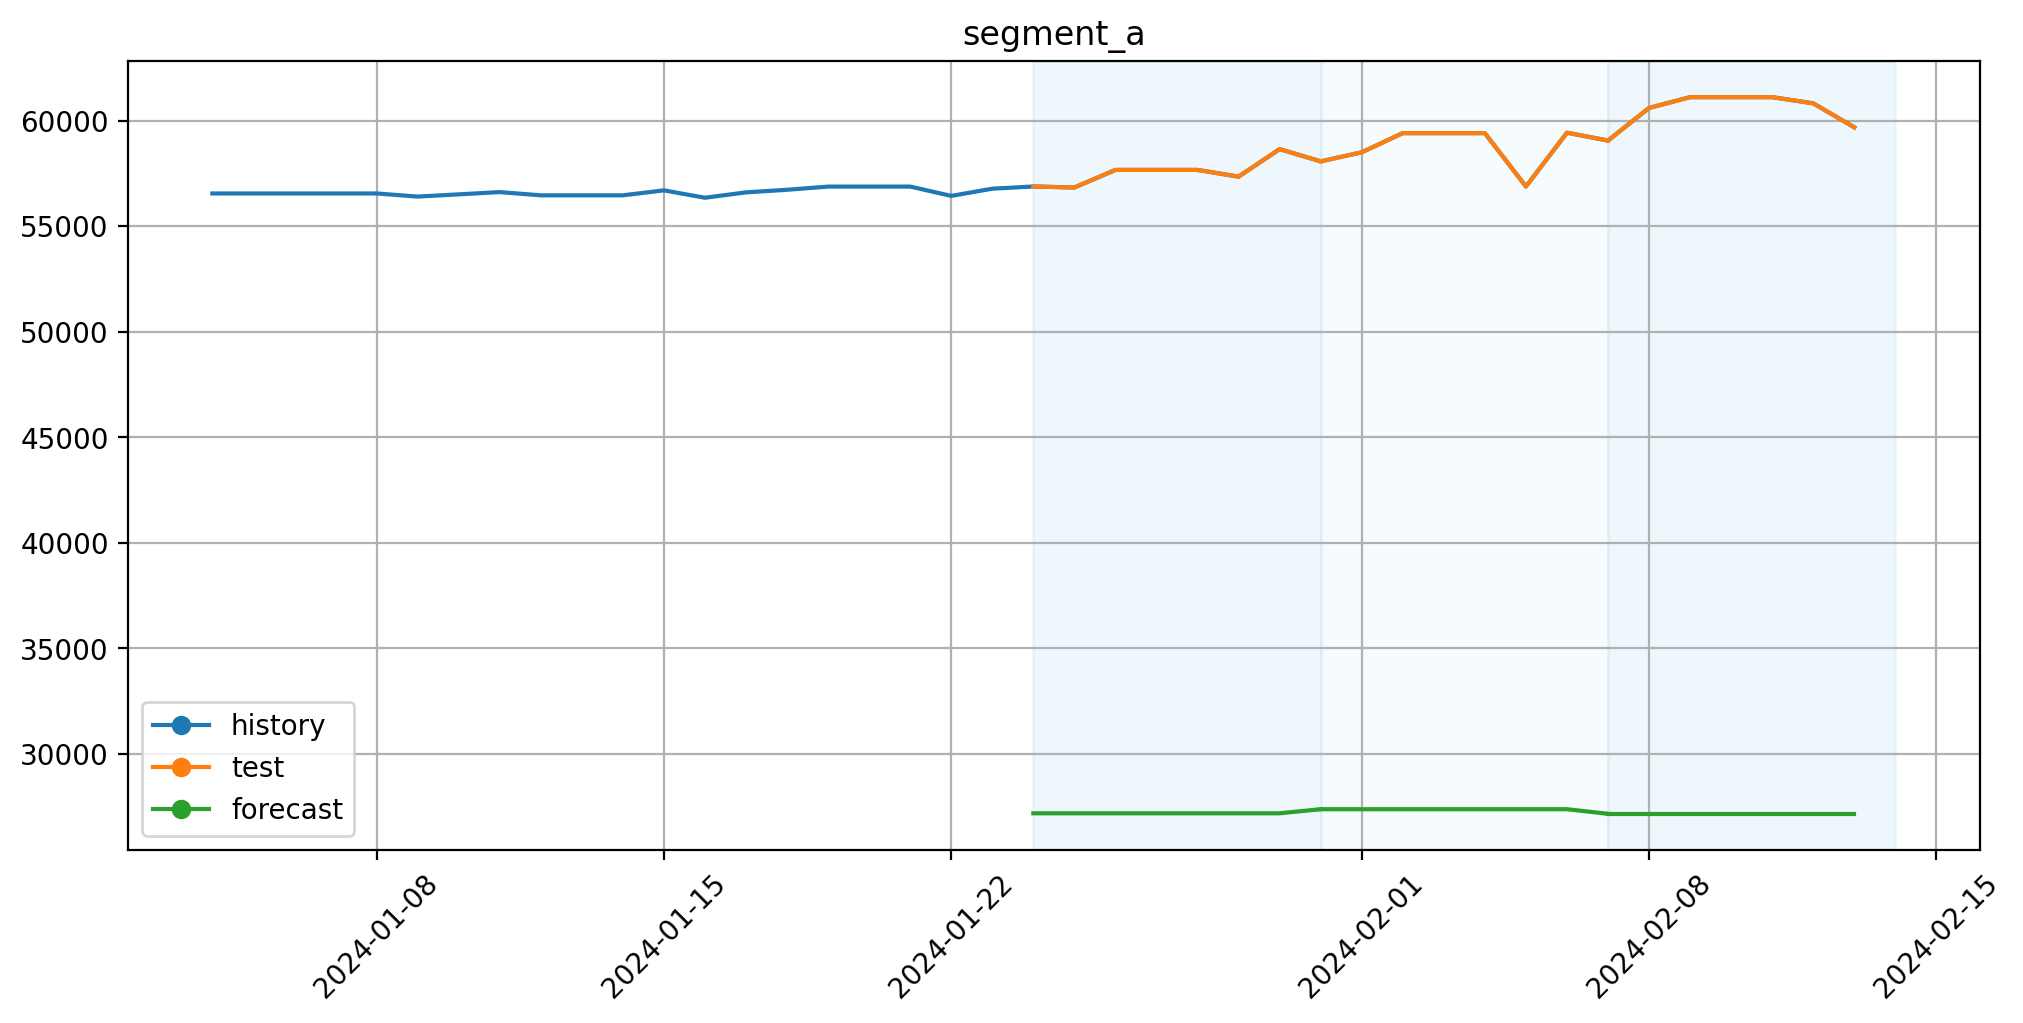

In [64]:
plot_backtest(forecast_tft, ts, history_len=20)

In [65]:
set_seed()

transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

dataset_builder_tft = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    static_categoricals=["segment"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

In [ ]:
model_tft = TFTModel(
    dataset_builder=dataset_builder_tft,
    trainer_params=dict(max_epochs=200, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date],
)

In [68]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [ ]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

In [ ]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

In [ ]:
plot_backtest(forecast_tft, ts, history_len=20)